In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import statsmodels.formula.api as smf
sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")

import utils

In [2]:
path = "/home/srs-9/Projects/ms_mri/analysis/thalamus/data0/chaco1_roi_means2.csv"
df_chaco = pd.read_csv(path, index_col="subid")
df = utils.load_data("/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data_wchaco.csv")

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [15]:
image_root = Path("/home/srs-9/Projects/ms_mri/analysis/thalamus/chaco/images")
for col in df_chaco.columns:
    plt.hist(df_chaco[col])
    plt.xlim([0,0.8])
    plt.title(col)
    plt.savefig(image_root / f"{col}_raw.png")
    plt.close()

In [16]:
transforms = utils.transforms
transforms['3root'] = lambda x: x**(1/3)
trans = "3root"
for col in df_chaco.columns:
    plt.hist(utils.transforms[trans](df_chaco[col]))
    # plt.xlim([0,0.8])
    plt.title(f"{col}, {trans}")
    plt.savefig(image_root / f"{col}_cuberoot.png")
    plt.close()

Text(0.5, 1.0, 'posterior')

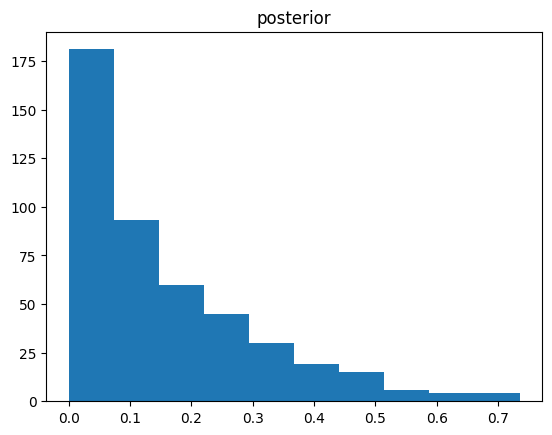

In [11]:
plt.hist(df_chaco['posterior'])
plt.title("posterior")

In [8]:
df_chaco.median(axis=0)

AV_2         0.041394
VA_4         0.061155
VLa_5        0.079061
VLP_6        0.085598
VPL_7        0.093936
Pul_8        0.103338
LGN_9        0.065011
MGN_10       0.117204
CM_11        0.091062
MD_Pf_12     0.053379
anterior     0.041394
ventral      0.082431
posterior    0.102825
medial       0.059740
dtype: float64

In [4]:
data = df[df['dz_type2'] == "MS"]
model_data = utils.zscore(data)
for struct in hips_thomas_ref[thalamic_nuclei]:
    outcome = f"{struct}_chaco_curoot"
    formula = f"{outcome} ~ T2LV_curoot + age + Female + tiv"
    res = smf.ols(formula, data=model_data).fit()
    print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      AV_2_chaco_curoot   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     451.3
Date:                Tue, 24 Feb 2026   Prob (F-statistic):          2.64e-156
Time:                        17:42:17   Log-Likelihood:                -281.00
No. Observations:                 457   AIC:                             572.0
Df Residuals:                     452   BIC:                             592.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0059      0.021     -0.281      

In [4]:
from scipy import stats
from itertools import combinations

groups = ['anterior', 'medial', 'posterior', 'ventral']
data = [df_chaco[g] for g in groups]

# Friedman test
stat, p = stats.friedmanchisquare(*data)
print(p)


4.829461103474168e-140


In [5]:
# Post-hoc pairwise Wilcoxon signed-rank with Holm correction
from statsmodels.stats.multitest import multipletests

pairs = list(combinations(groups, 2))
raw_p = []
for g1, g2 in pairs:
    _, p_pair = stats.wilcoxon(df_chaco[g1], df_chaco[g2])
    raw_p.append(p_pair)

reject, p_corrected, _, _ = multipletests(raw_p, method='holm')

for (g1, g2), p_raw, p_corr, rej in zip(pairs, raw_p, p_corrected, reject):
    print(f"{g1} vs {g2}: p_raw={p_raw:.4f}, p_holm={p_corr:.4f}, sig={rej}")

print("\n")
nuclei_groups = ["medial", "anterior", "ventral", "posterior"]
sorted_nuclei = sorted(nuclei_groups, key=lambda g: df_chaco[g].median())
max_width = max(len(nuclei) for nuclei in sorted_nuclei)
for nuclei in sorted_nuclei:
    print(f"{nuclei:<{max_width+1}}: {df_chaco[nuclei].median():0.2f} ({df_chaco[nuclei].quantile(0.25):0.2f}, {df_chaco[nuclei].quantile(0.75):0.2f})")

anterior vs medial: p_raw=0.0000, p_holm=0.0000, sig=True
anterior vs posterior: p_raw=0.0000, p_holm=0.0000, sig=True
anterior vs ventral: p_raw=0.0000, p_holm=0.0000, sig=True
medial vs posterior: p_raw=0.0000, p_holm=0.0000, sig=True
medial vs ventral: p_raw=0.0000, p_holm=0.0000, sig=True
posterior vs ventral: p_raw=0.0000, p_holm=0.0000, sig=True


anterior  : 0.04 (0.02, 0.10)
medial    : 0.06 (0.02, 0.15)
ventral   : 0.08 (0.03, 0.18)
posterior : 0.10 (0.04, 0.23)


In [11]:
from collections import defaultdict
from IPython.display import Markdown, HTML, display
import pyperclip

model_data = utils.zscore(df[df["dz_type2"]=="MS"], skip_vars=["PRL", "PRL_LEVEL", "HAS_PRL"])
model_data['HAS_PRL'] = model_data['HAS_PRL'].cat.codes.astype("int")
model_data['PRL_LEVEL'] = model_data['PRL_LEVEL'].astype("int")

trans = ""

results = defaultdict(list)
for nuc in sorted_nuclei:
    formula = f"{nuc} ~ {nuc}_chaco{trans} + T2LV{trans} + age + Female + tiv"
    res = smf.ols(formula, data=model_data).fit()
    results["coef (T2LV)"].append(res.params[f'T2LV{trans}'])
    results["pval (T2LV)"].append(res.pvalues[f'T2LV{trans}'])
    results["coef (chaco)"].append(res.params[f'{nuc}_chaco{trans}'])
    results["pval (chaco)"].append(res.pvalues[f'{nuc}_chaco{trans}'])

results_df = pd.DataFrame(results, index=sorted_nuclei)
results_md = results_df.to_markdown()
pyperclip.copy(results_md)
Markdown(results_md)

|           |   coef (T2LV) |   pval (T2LV) |   coef (chaco) |   pval (chaco) |
|:----------|--------------:|--------------:|---------------:|---------------:|
| anterior  |    -0.268452  |   2.13951e-05 |      -0.186309 |    0.00385013  |
| medial    |    -0.155134  |   0.00894874  |      -0.472878 |    7.12298e-14 |
| ventral   |    -0.0758809 |   0.198868    |      -0.441841 |    7.58012e-13 |
| posterior |    -0.0868626 |   0.101352    |      -0.609862 |    4.66012e-27 |